# 2. Frequency analysis

This tutorial covers basic frequency analysis of the EEG signal. The recording that is used is of a subject performing the SSVEP (steady-state visual evoked potential) paradigm. In simplest terms: when we look at a light that is flashing on and off at a certain frequency $f$, the neurons in our visual cortex will resonate at the same frequency (plus the harmonics $1f$, $2f$, $3f$, ...) This phenomenon can be used to create a brain-computer interface. Different options are presented on the screen, each flashing at a different frequency. By determining the frequency at which the visual cortex is resonating, the option that is attended can be distinguished from the rest.

In the current case, the subject is a witness in a cluedo murder mystery. He will try to communicate the murderer, weapon and location. The options available for selection, along with their corresponding frequency are as follows:

    Murderer:
        Colonel Mustard (8Hz)
        Miss Scarlett (10Hz)
        Professor Plum (12Hz)
        Reverend Green (15Hz)

    Weapon:
        Axe (8Hz)
        Poison (10Hz)
        Revolver (12Hz)
        Rope (15Hz)

    Location:
        Billiard Room (8Hz)
        Dining Room (10Hz)
        Kitchen (12Hz)
        Library (15Hz)



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The data is located on my public dropbox account. Again, running the code below will download the data, which will take some time depending on the speed of your internet connection.

**NOTE:** The data used in this tutorial is EEG data that has been bandpass filtered with a 3rd order Butterworth filter with a passband of 1.0-40 Hz. When performing analysis on other data, you might have to filter it yourself. Bandpass filtering is covered in the 3rd tutorial.

In [3]:
import urllib
urllib.urlretrieve('https://www.dropbox.com/s/kk6nwlmzrgfgmve/tutorial2-01.mat?dl=1', 'tutorial2-01.mat');

Using [`scipy.io.loadmat`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) to load the Matlab file and printing the variables stored within:

In [4]:
import scipy.io
m = scipy.io.loadmat('tutorial2-01.mat')
print m.keys()

['__header__', '__globals__', 'Murder_filteredEEG', 'Weapon_filteredEEG', '__version__', 'Room_filteredEEG']


The three variables of interest are `Murder_filteredEEG`, `Weapon_filteredEEG` and `Room_filteredEEG`:

In [5]:
murder_EEG = m['Murder_filteredEEG']
weapon_EEG = m['Weapon_filteredEEG']
room_EEG = m['Room_filteredEEG']

print 'Shape of murder_EEG:', murder_EEG.shape
print 'Shape of weapon_EEG:', weapon_EEG.shape
print 'Shape of room_EEG:', room_EEG.shape

Shape of murder_EEG: (14, 2560)
Shape of weapon_EEG: (14, 2560)
Shape of room_EEG: (14, 2560)


The data is recorded using the [Emotiv EPOC](http://www.emotiv.com) device. It has 14 channels and a sample rate of 128Hz:

In [6]:
nchannels, nsamples = murder_EEG.shape
sample_rate = 128.0

print 'Duration of recordings:', (nsamples / sample_rate), 'seconds'

Duration of recordings: 20.0 seconds


The subject was looking for 20 seconds at one of the four selection options. If we plot the [PSD](http://en.wikipedia.org/wiki/Spectral_density) (power spectral density) of the channels on the visual cortex, there should be a distinctive peak at the frequency of the attended option.

The algorithm to calculate a PSD is provided by the matplotlib toolbox as [`matplotlib.mlab.psd`](http://matplotlib.org/api/mlab_api.html):

In [7]:
from matplotlib.mlab import psd
psd?

Below is some code that calculates the PSD for some channels of the murderer EEG block:

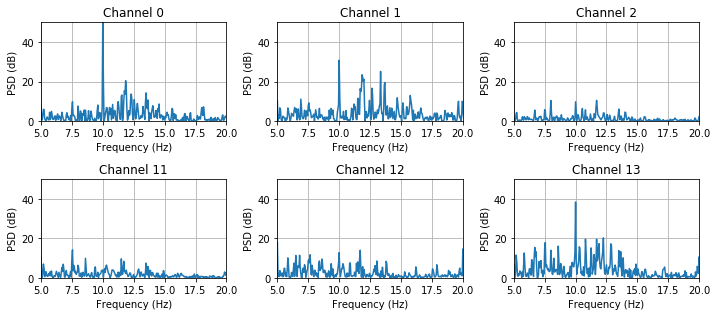

In [13]:
# These channels are roughly in the area covering the visual cortex
channels_of_interest = [0, 1, 2, 11, 12, 13]

# Create a new figure
figure(figsize=(10, 4.5))

# Draw the PSD of each channel of interest
for i,ch in enumerate(channels_of_interest):
    
    # The main plot is devided into 6 subplots: one for each channel
    # They are layed out in a grid: 2 rows and 3 columns
    subplot(2, 3, i+1)
    
    # Calculate the PSD (using a function in the matplotlib module)
    from matplotlib.mlab import psd
    (murder_PSD, freqs) = psd(murder_EEG[ch,:], NFFT=nsamples, Fs=sample_rate)

    # Plot the PSD
    plot(freqs, murder_PSD)
    
    # Each graph should have the same scale, otherwise we cannot compare them
    xlim(5, 20)
    ylim(0, 50)

    # Add some decoration
    grid(True)
    xlabel('Frequency (Hz)')
    ylabel('PSD (dB)')
    title('Channel %d' % ch)
    
# Instruct the plotting engine to use 'tight layout', otherwise labels are drawn on top of eachother
tight_layout()

The EEG recording made by the Emotiv EPOC is noisy: there are many peaks. Still, the peak at 10Hz is strongest as can be observed at channels 0 and 13. Therefore the conclusion is that the murderer is Miss Scarlett.

## Automatic classification

A common approach to automatically determine the frequency that is present most strongly is [Canonical Correlation Analysis (CCA)](http://en.wikipedia.org/wiki/Canonical_correlation) [1]. The idea is that an EEG recording of someone looking at a SSVEP stimulus with frequency $f$, will be highly correlated with a generated sine wave with the same frequency. More so than a generated sine wave with a different frequency. Under the condition that the EEG signal and the generated sine are in phase (e.g. the waveforms 'line up'). This condition is problematic, as we have no guarantee that this will be the case. To counter the phase shift, we correlate the EEG signal with both a sine and a cosine wave, following the same logic employed by the Fourier transform. If the sine wave correlates poorly, the cosine will correlate strongly and vice versa, as long as the frequencies match.

Simple correlation analysis only compares two vectors, lets call them $x$ and $y$. For example a single EEG channel and an artificial signal of the same length. In our case we have multiple EEG channels, so vector $x$ becomes a matrix $X$ with samples along the rows and channels in the columns. We are testing this signal against multiple sine and cosine waves, generated with frequence $f$ and also some harmonics of $f$ ($2f$ and $3f$ in this case). So $y$ becomes a matrix $Y$ with the generated samples in the rows and each column containing either a sine or cosine generated with some frequency.

The CCA procedure can be seen as a way to calculate the correlation between two sets of vectors simultaniously, a set of vectors being the same as a matrix. It does so be calculating a vector $u_0$, which is a linear combination of the columns of $X$ and a vector $v_0$, which is a linear combination of the columns of $Y$, in such a way that the correlation coefficient $\rho$ between $u_0$ and $v_0$ is maximal. It then goes on to calculate more vectors $u_1$ and $v_1$ that are uncorrelated with $u_0$ and $v_0$ and maximally correlated with each other. In our case however, we are only interested in the correlation between $u_0$ and $v_0$.

The task of our classifier is what we did manually before: to pick, out of the frequencies of all the stimuli on the screen, the one that best corresponds to what is present in the EEG signal. Therefore, for each frequency, we calculate a score for that frequency by performing CCA between the EEG signal and a matrix of generated sine/cosine waves with the frequency and its harmonics. Finally we pick the frequency with the highest score.

[1] Frequency recognition based on canonical correlation analysis for SSVEP-based BCIs. 
Lin, Zhonglin / Zhang, Changshui / Wu, Wei / Gao, Xiaorong, *IEEE transactions on bio-medical engineering*, 53 (12 Pt 2), p.2610-2614, Dec 2006, http://www.ncbi.nlm.nih.gov/pubmed/17152442

Below is the CCA classifier implemented as a Python function:

In [14]:
def ssvep_classifier(EEG, frequencies, sample_rate):
    '''
    SSVEP classifier based on Canonical Correlation Analysis (CCA).
    Given a list of frequencies, this function will return the frequency
    that is present the most strongly in some given EEG signal.
    '''
    nchannels, nsamples = EEG.shape
    
    # The matrix X is our EEG signal, but we transpose it so
    # observations (=samples) are on the rows and variables (=channels)
    # are on the columns.
    X = EEG.T

    # Keep track of the score for each frequency
    scores = []
    
    # Calculate a timeline in seconds, so we can construct
    # sine/cosine waves with the correct frequencies
    time = arange(nsamples) / float(sample_rate)
    
    # Calculate sines/cosines for all possible frequencies 
    for frequency in frequencies:
        
        # Calculate this part only once
        y = 2 * pi * frequency * time
    
        # Construct the matrix Y containing the base frequency and 2 harmonics
        Y = vstack((sin(y), cos(y), sin(2*y), cos(2*y), sin(3*y), cos(3*y))).T
    
        # Center the variables (= remove the mean)
        X = X - tile(mean(X, axis=0), (nsamples, 1))
        Y = Y - tile(mean(Y, axis=0), (nsamples, 1))
    
        # Perform Q-R decomposition. We only care about the Q part, ignore R
        QX,_ = linalg.qr(X)
        QY,_ = linalg.qr(Y)
    
        # Compute canonical correlations through SVD
        _, D, _ = linalg.svd(QX.T.dot(QY))
        
        # Note the highest (= first) coefficient as the final score for this frequency
        scores.append(D[0])
        
    # Return the frequency with the highest score
    return frequencies[ argmax(scores) ]

Putting the classifier to work, lets solve the murder completely:

In [15]:
print 'Murderer frequency: %d Hz.' % ssvep_classifier(murder_EEG, [8, 10, 12, 15], 128)
print 'Weapon frequency:   %d Hz.' % ssvep_classifier(weapon_EEG, [8, 10, 12, 15], 128)
print 'Room: frequency:    %d Hz.' % ssvep_classifier(room_EEG, [8, 10, 12, 15], 128)

Murderer frequency: 10 Hz.
Weapon frequency:   15 Hz.
Room: frequency:    12 Hz.


Looking at the table at the beginning of this tutorial, this means Miss Scarlett was the murderer, using a rope in the kitchen.